In [ ]:
import pandas as pd
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, confusion_matrix, classification_report, recall_score
import numpy as np

# Mainīgo definēšana
batch_size = 16
epoch_count = 5
num_labels = 4
num_folds = 5

# Ielādējam datus
df = pd.read_csv('./drive/MyDrive/ColabNotebooks/Data/ModifiedTransformed_V2.csv')

# Ielādējam priekšapmācitu vārdu dalitāju teksta vienībās
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

texts = df['FullDescription'].tolist()
labels = df['Int_RootCauseCategory'].tolist()

# Pārveidojam tekstu
labels = np.array(labels)

# Inicializējam šķērsvalidāciju (StratifiedKFold K-Fold Cross-Validation)
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Mainīgo definēšana (statistika)
fold = 1
all_fold_accuracies = []
all_fold_f1_scores = []
all_fold_precisions = []
all_fold_recalls = []
all_fold_confusion_matrices = []

# Šķērsvalidācijas cikls
for train_index, val_index in skf.split(texts, labels):
    print(f"Cikls: {fold}/{num_folds}")

    # Sadalam datus apmācības un validācijas datukopās
    X_train, X_val = np.array(texts)[train_index], np.array(texts)[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Veicam teksta sadalīšanu marķieros
    train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512, return_tensors="tf")
    val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=512, return_tensors="tf")

    # Izveidojam apmācībās un validācijas datukopas no marķieriem
    train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val)).batch(batch_size)

    # Katram jaunam ciklam veicam jauna modeļa inicializāciju
    model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)

    # Kompilējam modeli
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # Apmācam modeli
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epoch_count,
        verbose=1
    )

    # Apmācītā modeļa validācija ar validācijas datukopu.
    # Nosakam validācijas ticamību.
    val_loss, val_accuracy = model.evaluate(val_dataset)
    print(f"Cikls {fold} - Validācijas ticamība: {val_accuracy:.4f}")
    all_fold_accuracies.append(val_accuracy)

    # Veicam prognozēšanu un iegūstam rezultātu
    y_pred_logits = model.predict(val_dataset).logits
    y_pred = np.argmax(y_pred_logits, axis=1)

    # Nosakam F1 mēru
    fold_f1_score = f1_score(y_val, y_pred, average='weighted')
    print(f"Cikls {fold} - F1 mērs: {fold_f1_score:.4f}")
    all_fold_f1_scores.append(fold_f1_score)

    # Nosakam Precizitātes vērtību
    fold_precision = precision_score(y_val, y_pred, average='weighted')
    print(f"Cikls {fold} - Precizitāte: {fold_precision:.4f}")
    all_fold_precisions.append(fold_precision)

    # Nosakam Atsaukšanas (Recall) vērtību
    fold_recall = recall_score(y_val, y_pred, average='weighted')
    print(f"Cikls {fold} - Atsaukšanas (Recall) vērtība: {fold_recall:.4f}")
    all_fold_recalls.append(fold_recall)

    # Veidojam kļūdu matricu
    cm = confusion_matrix(y_val, y_pred)
    print(f"Cikls {fold} - Kļūdu matrica:\n{cm}")
    all_fold_confusion_matrices.append(cm)

    fold += 1

# Apvienojam visas kļūdu matricas, lai iegūtu kopējo versiju
overall_confusion_matrix = np.sum(all_fold_confusion_matrices, axis=0)

# Šķērsvalidācijas rezultāti
mean_accuracy = np.mean(all_fold_accuracies)
mean_f1_score = np.mean(all_fold_f1_scores)
mean_precision = np.mean(all_fold_precisions)
mean_recall = np.mean(all_fold_recalls)

print(f"\nŠķērsvalidācijas vispārējā vidējā Ticamība (Accuracy): {mean_accuracy:.4f}")
print(f"Šķērsvalidācijas vispārējā vidējā F1 mēra vērtība (F1 score): {mean_f1_score:.4f}")
print(f"Šķērsvalidācijas vispārējā vidējā Precizitāte (Precission): {mean_precision:.4f}")
print(f"Šķērsvalidācijas vispārējā vidējā Atsaukšana (Recall): {mean_recall:.4f}")

Cikls: 1/5


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5
145/145 [==============================] - 38s 148ms/step - loss: 1.1167 - accuracy: 0.5078 - val_loss: 1.0880 - val_accuracy: 0.5423
Epoch 2/5
145/145 [==============================] - 17s 118ms/step - loss: 0.9920 - accuracy: 0.6002 - val_loss: 1.0192 - val_accuracy: 0.5769
Epoch 3/5
145/145 [==============================] - 17s 119ms/step - loss: 0.8139 - accuracy: 0.6969 - val_loss: 1.0782 - val_accuracy: 0.5579
Epoch 4/5
145/145 [==============================] - 17s 118ms/step - loss: 0.6653 - accuracy: 0.7638 - val_loss: 1.2161 - val_accuracy: 0.5561
Epoch 5/5
37/37 [==============================] - 1s 38ms/step - loss: 1.5690 - accuracy: 0.5026
Cikls 1 - Validācijas ticamība: 0.5026
37/37 [==============================] - 3s 37ms/step
Cikls 1 - F1 mērs: 0.4888
Cikls 1 - Precizitāte: 0.5789
Cikls 1 - Atsaukšanas (Recall) vērtība: 0.5026
Cikls 1 - Kļūdu matrica:
[[ 97  33   3   0]
 [ 32  84  13   0]
 [ 84  88 110   0]
 [ 10  15  10   0]]
Cikls: 2/5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceCl

Epoch 1/5
145/145 [==============================] - 39s 150ms/step - loss: 1.1154 - accuracy: 0.5039 - val_loss: 1.0504 - val_accuracy: 0.5665
Epoch 2/5
145/145 [==============================] - 17s 119ms/step - loss: 0.9797 - accuracy: 0.6131 - val_loss: 0.9758 - val_accuracy: 0.6114
Epoch 3/5
145/145 [==============================] - 17s 120ms/step - loss: 0.7991 - accuracy: 0.7085 - val_loss: 1.0266 - val_accuracy: 0.6218
Epoch 4/5
145/145 [==============================] - 17s 119ms/step - loss: 0.6416 - accuracy: 0.7807 - val_loss: 1.2898 - val_accuracy: 0.5648
Epoch 5/5
37/37 [==============================] - 1s 39ms/step - loss: 1.4698 - accuracy: 0.5320
Cikls 2 - Validācijas ticamība: 0.5320
37/37 [==============================] - 3s 37ms/step
Cikls 2 - F1 mērs: 0.5260
Cikls 2 - Precizitāte: 0.5739
Cikls 2 - Atsaukšanas (Recall) vērtība: 0.5320
Cikls 2 - Kļūdu matrica:
[[ 92  29  11   0]
 [ 45  75  10   0]
 [ 71  70 141   0]
 [  8  11  16   0]]
Cikls: 3/5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceCl

Epoch 1/5
145/145 [==============================] - 37s 148ms/step - loss: 1.1040 - accuracy: 0.5276 - val_loss: 1.1330 - val_accuracy: 0.5216
Epoch 2/5
145/145 [==============================] - 17s 118ms/step - loss: 0.9662 - accuracy: 0.6205 - val_loss: 1.0594 - val_accuracy: 0.5734
Epoch 3/5
145/145 [==============================] - 17s 118ms/step - loss: 0.8152 - accuracy: 0.7042 - val_loss: 1.1279 - val_accuracy: 0.5596
Epoch 4/5
145/145 [==============================] - 17s 118ms/step - loss: 0.6575 - accuracy: 0.7664 - val_loss: 1.4335 - val_accuracy: 0.4888
Epoch 5/5
37/37 [==============================] - 1s 38ms/step - loss: 1.4372 - accuracy: 0.5389
Cikls 3 - Validācijas ticamība: 0.5389
37/37 [==============================] - 3s 37ms/step
Cikls 3 - F1 mērs: 0.5372
Cikls 3 - Precizitāte: 0.6266
Cikls 3 - Atsaukšanas (Recall) vērtība: 0.5389
Cikls 3 - Kļūdu matrica:
[[ 64  55  14   0]
 [ 19  90  21   0]
 [ 25 100 157   0]
 [  2   7  24   1]]
Cikls: 4/5


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5
145/145 [==============================] - 39s 148ms/step - loss: 1.1461 - accuracy: 0.4931 - val_loss: 1.0740 - val_accuracy: 0.5475
Epoch 2/5
145/145 [==============================] - 17s 119ms/step - loss: 1.0235 - accuracy: 0.5877 - val_loss: 0.9450 - val_accuracy: 0.6304
Epoch 3/5
145/145 [==============================] - 17s 118ms/step - loss: 0.8602 - accuracy: 0.6839 - val_loss: 1.0136 - val_accuracy: 0.5699
Epoch 4/5
145/145 [==============================] - 17s 119ms/step - loss: 0.6752 - accuracy: 0.7612 - val_loss: 1.3030 - val_accuracy: 0.5130
Epoch 5/5
37/37 [==============================] - 1s 38ms/step - loss: 1.4446 - accuracy: 0.5026
Cikls 4 - Validācijas ticamība: 0.5026
37/37 [==============================] - 3s 37ms/step
Cikls 4 - F1 mērs: 0.5018
Cikls 4 - Precizitāte: 0.5845
Cikls 4 - Atsaukšanas (Recall) vērtība: 0.5026
Cikls 4 - Kļūdu matrica:
[[ 82  44   7   0]
 [ 31  89  10   0]
 [ 28 132 120   2]
 [  6  13  15   0]]
Cikls: 5/5


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5
145/145 [==============================] - 38s 150ms/step - loss: 1.1367 - accuracy: 0.5160 - val_loss: 1.1138 - val_accuracy: 0.5596
Epoch 2/5
145/145 [==============================] - 17s 119ms/step - loss: 1.0172 - accuracy: 0.6079 - val_loss: 0.9745 - val_accuracy: 0.6149
Epoch 3/5
145/145 [==============================] - 17s 119ms/step - loss: 0.8688 - accuracy: 0.6801 - val_loss: 1.0211 - val_accuracy: 0.5855
Epoch 4/5
145/145 [==============================] - 17s 119ms/step - loss: 0.6850 - accuracy: 0.7647 - val_loss: 1.0852 - val_accuracy: 0.5959
Epoch 5/5
37/37 [==============================] - 1s 38ms/step - loss: 1.0310 - accuracy: 0.6390
Cikls 5 - Validācijas ticamība: 0.6390
37/37 [==============================] - 3s 38ms/step
Cikls 5 - F1 mērs: 0.6220
Cikls 5 - Precizitāte: 0.6526
Cikls 5 - Atsaukšanas (Recall) vērtība: 0.6390
Cikls 5 - Kļūdu matrica:
[[ 82  26  25   0]
 [ 30  60  40   0]
 [ 26  31 225   0]
 [  4   3  24   3]]

Šķērsvalidācijas vispārējā 

In [ ]:
# Saglabājam modeli
model.save_pretrained('./drive/MyDrive/ColabNotebooks/TrainedModel/BertDistil_RootCausePrediction')
tokenizer.save_pretrained('./drive/MyDrive/ColabNotebooks/TrainedModel/BertDistil_RootCausePrediction')

('./drive/MyDrive/ColabNotebooks/TrainedModel/BertDistil_RootCausePrediction/tokenizer_config.json',
 './drive/MyDrive/ColabNotebooks/TrainedModel/BertDistil_RootCausePrediction/special_tokens_map.json',
 './drive/MyDrive/ColabNotebooks/TrainedModel/BertDistil_RootCausePrediction/vocab.txt',
 './drive/MyDrive/ColabNotebooks/TrainedModel/BertDistil_RootCausePrediction/added_tokens.json')

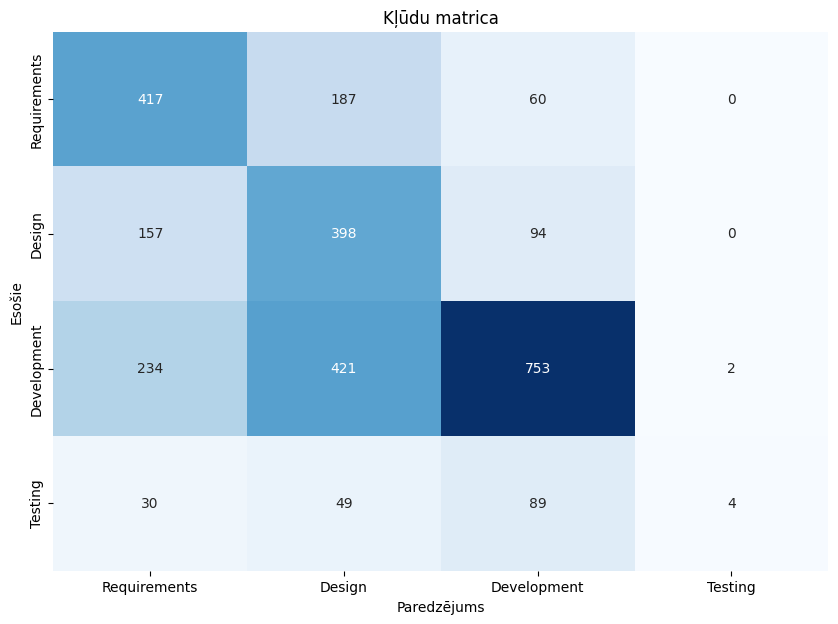

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Definējam teksta vērtībām atbilstošās skaitliskās vērtības.
categories = {
    'Requirements': 0,
    'Design': 1,
    'Development': 2,
    'Testing': 3
}

# Veidojma kļūdu matricu
plt.figure(figsize=(10, 7))
sns.heatmap(overall_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories.keys(), yticklabels=categories.keys(), cbar=False)

# Definējam nosaukumus
plt.xlabel('Paredzējums')
plt.ylabel('Esošie')
plt.title('Kļūdu matrica')
plt.show()

In [ ]:
# Paredzējums
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

loaded_model = TFDistilBertForSequenceClassification.from_pretrained('./drive/MyDrive/ColabNotebooks/TrainedModel/BertDistil_RootCausePrediction')
loaded_tokenizer = DistilBertTokenizer.from_pretrained('./drive/MyDrive/ColabNotebooks/TrainedModel/BertDistil_RootCausePrediction')

def predictPhase(bugText):
  # Pārveidojam kategorijas uz skaitļu vērtībām
  categories = {
      'Requirements': 0,
      'Design': 1,
      'Development': 2,
      'Testing': 3
  }
  # Pārveidojam skaitļu vērtības uz teksta vērtībām
  reverse_categories = {v: k for k, v in categories.items()}

  # Veicam teksta sadalīšanu marķieros
  inputs_encodings = loaded_tokenizer(bugText, truncation=True, padding=True, max_length=512, return_tensors="tf")

  logits = loaded_model(inputs_encodings).logits
  prediction = tf.argmax(logits, axis=1).numpy()[0]
  return reverse_categories[prediction]


defect_Description_for_prediction = 'database title column type must be changed to integer'

predict_phase = predictPhase(defect_Description_for_prediction)
print(f"Defekta apraksts '{defect_Description_for_prediction}' attiecas uz '{predict_phase}' fāzi.")

Some layers from the model checkpoint at ./drive/MyDrive/ColabNotebooks/TrainedModel/BertDistil_RootCausePrediction were not used when initializing TFDistilBertForSequenceClassification: ['dropout_259']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./drive/MyDrive/ColabNotebooks/TrainedModel/BertDistil_RootCausePrediction and are newly initialized: ['dropout_379']
You should probably TRAIN this model on a down-stream task to be ab

Defekta apraksts 'database title column type must be changed to integer' attiecas uz 'Requirements' fāzi.
